In [60]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import os
import mplleaflet
from itertools import chain

In [2]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [3]:
crimes = pd.DataFrame()

mypath = './metropolitan_all'
# for (dirpath, dirnames, filenames) in os.walk(mypath):
#     if dirpath is not './metropolitan_all':
#         for filename in filenames:
#             if 'csv' in filename and '2015' in filename:
#                 frame = pd.read_csv(dirpath + '/' + filename)
#                 crimes = crimes.append(frame, ignore_index=True)
frame = pd.read_csv('./metropolitan_all/2015-08/2015-08-city-of-london-street.csv')
crimes = crimes.append(frame, ignore_index=True)
frame = pd.read_csv('./metropolitan_all/2015-08/2015-08-metropolitan-street.csv')
crimes = crimes.append(frame, ignore_index=True)
len(crimes)

81841

In [4]:
crimes = crimes.dropna(axis=0, subset=['LSOA code'])
len(crimes)

80813

In [5]:
crimes = crimes[['Month','LSOA code',"Longitude","Latitude",'Crime type']]

In [43]:
london_wards = gpd.GeoDataFrame().from_file('./london/london_wards.shp')
wards_polygon = prep(MultiPolygon(list(london_wards.geometry)))
lsoas = gpd.GeoDataFrame().from_file('./LSOA/LSOA_2011_EW_BGC_V2.shp')
lsoas = lsoas.to_crs(epsg=4326)
lsoas_london = gpd.GeoDataFrame(lsoas.apply(lambda row: row if wards_polygon.intersects(row.geometry) else None, axis=1))
lsoas_london = lsoas_london.dropna()

None
None


In [44]:
crime_count = crimes.loc[:,('LSOA code')].value_counts()
lsoas_london = lsoas_london.join(crime_count, on='LSOA11CD')
lsoas_london['crime_count'] = lsoas_london['LSOA code']
lsoas_london = lsoas_london.drop('LSOA code', axis=1)

None
None
None
None


In [53]:
lsoas_london = gpd.GeoDataFrame(lsoas_london)
lsoas_london.crs = lsoas.crs
lsoas_london['density_km'] = lsoas_london['crime_count'] / (lsoas_london.to_crs(epsg=32630).area/10**6)
# it's easier to work with NaN values when classifying
lsoas_london.replace(to_replace={'density_km': {0: np.nan}}, inplace=True)

In [54]:
breaks = nb(
    lsoas_london[lsoas_london['density_km'].notnull()].density_km.values,
    initial=300,
    k=5)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=lsoas_london[lsoas_london['density_km'].notnull()].index)
lsoas_london.drop(['jenks_bins'],axis=1,inplace=True, errors='ignore')
lsoas_london = lsoas_london.join(jb)
lsoas_london.jenks_bins.fillna(-1, inplace=True)

In [55]:
jenks_labels = ["<= %0.1f/km$^2$(%s wards)" % (b, c) for b, c in zip(
    breaks.bins, breaks.counts)]
jenks_labels.insert(0, 'No crimes (%s wards)' % len(lsoas_london[lsoas_london['density_km'].isnull()]))

In [73]:
#for some reason getting multipolygons from the data
lsoas_london = lsoas_london.apply(lambda row: row if type(row.geometry) is Polygon else None, axis=1)

In [75]:
lsoas_london = lsoas_london.dropna()

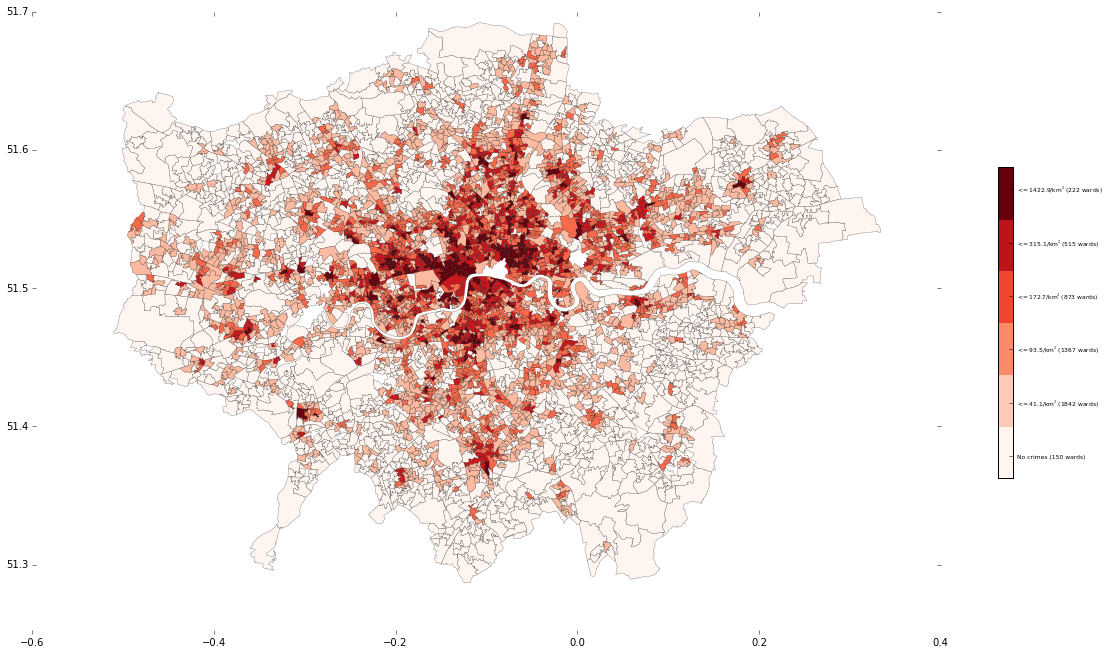

In [79]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Reds')
# draw wards with grey outlines
patches = gpd.GeoSeries(
    lsoas_london.geometry.map(lambda x: PolygonPatch(x, ec='#000000', lw=.2, alpha=1., zorder=9))
)
pc = PatchCollection(patches, match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(lsoas_london['jenks_bins'].values)))
ax.add_collection(pc)

ax.autoscale() 

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=6)

# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(20, 10)
plt.savefig('london_crimes_density.png', dpi=300, alpha=True)
plt.show()

In [78]:
mplleaflet.show(fig=ax.figure, crs=lsoas_london.crs, tiles='cartodb_positron')